## Biblotecas

In [2]:
import sys
!{sys.executable} -m pip install datasets matplotlib transformers


from datasets import Dataset

import matplotlib.pyplot as plt
from transformers import BertTokenizerFast
import time as tm
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

'c:\Program' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
C:\Users\samug\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Map: 100%|██████████| 1/1 [00:00<00:00, 168.12 examples/s]

2000 2000


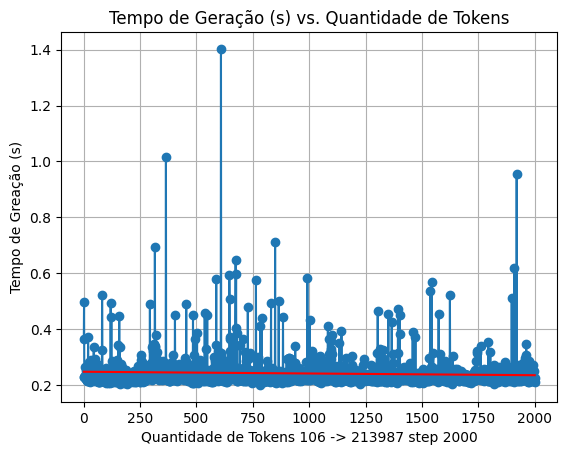

In [10]:
start_time = tm.time()

# Carregar texto do livro
with open("a_revolucao_dos_bichos.txt", "r", encoding="utf-8") as f:
    livro = f.read()

# Dividir por parágrafos (ou capítulos)
paragrafos = [p.strip() for p in livro.split("\n")]

# Visualizar alguns trechos
divisions = 2000
porcentagens = [x for x in range(1,divisions+1)]
tamanhos = [int(len(paragrafos[0])*x/divisions) for x in porcentagens]
tempos = []
for prc in porcentagens:
    st_tk = tm.time()
    contexto = [paragrafos[0][:prc]]
    # print(f"Contexto: {len(contexto)}")

    data = {
        "id": ["1"],
        "title": ["A Revolução dos Bichos"],
        "context": contexto,
        "question": ["Quem inspirou os animais com um discurso revolucionário?"],
        "answers": [{"text": ["Major"], "answer_start": [prc]}]  # ajuste conforme necessário
    }
    
    dataset = Dataset.from_dict(data)
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

    def preprocess(example):
        
        inputs = tokenizer(
            example["question"],
            example["context"],
            truncation=True,
            padding="max_length",
            max_length=384,
            return_offsets_mapping=True
        )

        # Pega posição inicial da resposta
        answer = example["answers"]["text"][0]
        start_char = example["answers"]["answer_start"][0]
        end_char = start_char + len(answer)

        # Offset mapping: onde cada token aparece no texto original
        offsets = inputs["offset_mapping"]

        start_pos = end_pos = None
        for i, (start, end) in enumerate(offsets):
            if start <= start_char < end:
                start_pos = i
            if start < end_char <= end:
                end_pos = i
                break

        # fallback caso a correspondência seja exata
        if start_pos is None:
            start_pos = 0
        if end_pos is None:
            end_pos = 0

        inputs["start_positions"] = start_pos
        inputs["end_positions"] = end_pos
        inputs.pop("offset_mapping")  # remover para evitar erro
        

        return inputs


    encoded_dataset = dataset.map(preprocess)
    tm_tk = tm.time() - st_tk
    # print(f"Tempo de tokenização: {tm_tk}")
    tempos.append(tm_tk)


def grafic():
    # Redimensionar x para formato (n_amostras, 1)
    print(f"{len(porcentagens)} {len(tempos)}")
    x = np.array(porcentagens)
    y = np.array(tempos)

    x_reshape = x.reshape(-1, 1)

    # Criar e treinar o modelo de regressão
    modelo = LinearRegression()
    modelo.fit(x_reshape, y)

    # Previsão para os mesmos x
    y_pred = modelo.predict(x_reshape)

    # Visualização
    # plt.scatter(x, y, color='blue', label='Pontos')

    plt.plot(porcentagens,tempos,marker="o")
    plt.plot(x, y_pred, color='red', label='Regressão linear')
    plt.xlabel(f"Quantidade de Tokens {tamanhos[0]} -> {tamanhos[-1]} step {divisions}")
    plt.ylabel("Tempo de Greação (s)")
    plt.title("Tempo de Geração (s) vs. Quantidade de Tokens")
    plt.grid(True)
    plt.show()

grafic()



## Pipeline

In [11]:

from transformers import BertForQuestionAnswering, TrainingArguments, Trainer

model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

training_args = TrainingArguments(
    output_dir="./bert-qa-revolucao_001",
    num_train_epochs=2,
    per_device_train_batch_size=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
)

trainer.train()


# Seu código aqui

from transformers import pipeline

qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\samug\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Device set to use cpu


## Questions

In [12]:
resposta = qa_pipeline({
    "context": paragrafos[0],
    "question": "Napoleão morre?"
})

print("1_Resposta:", resposta["answer"])

result = sum(range(1000000))
end_time = tm.time()
execution_time = end_time - start_time
print(f"1_Tempo de execução: {execution_time:.4f} segundos")


# step = 250
# teto = 15000
# min = 5000
# tokens = [min+x*step for x in range((int) ((teto-min)/step+1))]
# for qtdTokens in tokens:
#     qtd = (int) (qtdTokens)
#     tempo = takeTime(filecontent[0:qtd],qtd)
#     tempos.append(tempo)
#     print(f"Tokens: {qtd}; Tempo: {tempo}s")

# plt.plot(tokens,tempos,marker="")
# plt.xlabel(f"Quantidade de Tokens {min} -> {teto} step {step}")
# plt.ylabel("Tempo de Greação (s)")
# plt.title("Tempo de Geração (s) vs. Quantidade de Tokens c/ armazenamento")
# plt.grid(True)
# plt.show()

C:\Users\samug\AppData\Roaming\Python\Python311\site-packages\transformers\pipelines\question_answering.py:390: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


1_Resposta: Public Schools. [Nota de Orwell]
1_Tempo de execução: 836.9834 segundos
